In [1]:
import pandas as pd
import numpy as np
# import category_encoders as ce
# import copy
# import polars as pl

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import matplotlib
import seaborn as sns
# import plotly.express as px
# %matplotlib inline
# matplotlib.rcParams['font.family'] = 'Malgun Gothic' # 한글 패치
# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.decomposition import PCA

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
# from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor, XGBRFRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, VotingRegressor
from sklearn.ensemble import StackingClassifier, StackingRegressor
# from sklearn.base import ClassifierMixin

# CatBoost
# from catboost import CatBoostRegressor

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss,mean_squared_error
import sklearn

# Utility
import os
import time
import datetime # ⚠️2019년 12월30일과 31일의 week of year가 1인 오류가 있음
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean
import holidays

# from bayes_opt import BayesianOptimization
# from num2words import num2words
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

In [2]:
pd.set_option('display.max_row',None)
pd.set_option('display.max_column',None)

### Setting universal random_state
np.random.seed(142)
random.seed(142)
sklearn.utils.check_random_state(142)
torch.manual_seed(142)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Note: not using Google CoLab
Using device: cuda


In [3]:
class PrepareData():
    def __init__(self,stock_fp,news_fp):
        self.stock_filepath = stock_fp
        self.news_filepath = news_fp
        self.topic_classes = ['CEO', 'CFO', 'Layoffs', 'Political', 'PressRelease', 'Undefined',
       'cramer', 'earnings', 'gold', 'manda', 'paylimitwall', 'paywall',
       'product', 'recession', 'tanalysis'] # undefined의 class가 5

    def load_data(self):
        stock = pd.read_csv(self.stock_filepath,index_col=0)
        news = pd.read_csv(self.news_filepath,index_col=0)
        ### parse date manually
        stock['Date'] = pd.to_datetime(stock['Date'])
        news['date'] = pd.to_datetime(news['date'])
        return stock, news

    def merging(self, stock, news):
        ### fill na value of PINS column
#         stock['PINS'] = stock['PINS'].fillna(stock['PINS'].iloc[75])

        ### drop 'news_id' column
#         news = news.drop(columns=['news_id'])

        ### add date range from 18.01.02 to 18.12.31
        temp_range = pd.DataFrame(dict(zip(stock.columns,[pd.date_range(start='2018-01-02',end='2018-12-31'),
                                0,0,0,0, # 4
                                0,0,0,0,
                                0,0,0,0,
                                0,0,0,0, # 16
                                0,0,0,0,
                                0,0,0,0,
                                0,0,0,0, # 28
                                0,0,0,0,
                                0,0,0,0, # 36
                                0 # 37
                            ])))
        stock_inc = pd.concat([temp_range,stock],axis=0)

        ### merge stock_inc and news
        # left = stock_inc
        # on = date
        # how = left
        # rename 'date' to 'Date' of news df
        news = news.rename(columns={'date':'Date'})
        merged = pd.merge(left=stock_inc,right=news,on='Date',how='left')

        ### Cut before 2018-02-13
        merged = merged[42:].reset_index(drop=True)

        # fill na with latest non-null values
        columns_to_fill = ['source_name', 'topics', 'rank_score',
                        'sentiment_Negative','sentiment_Neutral',
                        'sentiment_Positive', 'type_Article', 'type_Video']
        merged_fillna = merged.copy()
        for column in columns_to_fill:
            merged_fillna[column].fillna(method='ffill',inplace=True)

        ### add moving average to sentiments
        ma_nums = [5,60,120]
        def mode_window(window):
            return window.mode().iloc[0] if not len(window.mode())==0 else None
        for num in ma_nums:
            merged_fillna[f'{num}MA_sent_Neg']=merged_fillna['sentiment_Negative'].rolling(
            window=num).mean()
            merged_fillna[f'{num}MA_sent_Neu']=merged_fillna['sentiment_Neutral'].rolling(
            window=num).mean()
            merged_fillna[f'{num}MA_sent_Pos']=merged_fillna['sentiment_Positive'].rolling(
            window=num).mean()
        ### add moving mode to sentiments
        for num in ma_nums:
            merged_fillna[f'{num}MM_sent_Neg']=merged_fillna['sentiment_Negative'].rolling(
            window=num).apply(mode_window)
            merged_fillna[f'{num}MM_sent_Neu']=merged_fillna['sentiment_Neutral'].rolling(
            window=num).apply(mode_window)
            merged_fillna[f'{num}MM_sent_Pos']=merged_fillna['sentiment_Positive'].rolling(
            window=num).apply(mode_window)
        ### adding moving mode to topics
        for num in ma_nums:
            merged_fillna[f'{num}MM_topics']=merged_fillna['topics'].rolling(
            window=num).apply(mode_window)

        ### drop before 2019-01-02
        total_df = merged_fillna.iloc[322:]
        total_df = total_df.reset_index(drop=True)

        ### drop unnecessaray columns
        drop_cols = ['source_name','topics','rank_score',
                    'sentiment_Negative','sentiment_Neutral',
                    'sentiment_Positive','type_Article','type_Video']
        total_df = total_df.drop(columns=drop_cols)

        return total_df
    
stock_filepath = '../../data/stock_price/netflix_60.csv' # 각자 파일 경로 설정
news_filepath = '../../data/scraping/news_processed_filtered_2.csv'
# stock_filepath = './drive/MyDrive/Colab Notebooks/data/bitamin_mini_project/netflix_60.csv'
# news_filepath = './drive/MyDrive/Colab Notebooks/data/bitamin_mini_project/news_processed_filtered_2.csv'
loader = PrepareData(stock_filepath, news_filepath)
stock_df, news_df=loader.load_data() # >> 감성분석 미포함으로 모델 돌릴 땐 stock_df 바로 사용하면 됨
total_df = loader.merging(stock=stock_df, news=news_df) # 주식데이터셋에 감성분석,토픽 포함시킨 전체 데이터셋
testfile = '../../data/test.csv'
test_df = pd.read_csv(testfile)

stock_df.index = stock_df["Date"]
stock_df.drop(columns = "Date", inplace = True)
stock_df["PINS"].fillna(24.99, inplace = True)
total_df.index = total_df["Date"]
total_df.drop(columns = "Date", inplace = True)
total_df["PINS"].fillna(24.99, inplace = True)

In [23]:
final_df = pd.read_csv('../../data/results/final_all_results.csv',index_col=0)
# final_df = final_df.drop(columns=['r_squared_total','r_squared_stock','p_value_total','p_value_stock'])
final_df.head(5)

,seq_size,batch_size,output_size,hidden_size,error_ratio_total,r_squared_total,p_value_total,error_ratio_stock,r_squared_stock,p_value_stock
0,30,1,10,64,0.203406,0.024201,0.667815,0.045170,0.407733,0.046916
1,30,1,10,128,0.157909,0.003318,0.874408,0.021650,0.008583,0.799068
2,30,1,10,256,0.031342,0.030070,0.631873,0.089128,0.183508,0.216778
3,30,1,20,64,0.121427,0.132527,0.114582,0.052569,0.201426,0.047152
4,30,1,20,128,0.100733,0.680947,0.000008,0.056673,0.068630,0.264519


In [26]:
final_df[(final_df['error_ratio_total']<0.1) & (final_df['error_ratio_stock']<0.1)]

,seq_size,batch_size,output_size,hidden_size,error_ratio_total,r_squared_total,p_value_total,error_ratio_stock,r_squared_stock,p_value_stock
2,30,1,10,256,0.031342,0.030070,0.631873,0.089128,0.183508,0.216778
31,60,1,10,128,0.064752,0.438934,0.036843,0.091416,0.536254,0.016026
33,60,1,20,64,0.076007,0.018572,0.566714,0.054516,0.439437,0.001445
34,60,1,20,128,0.047786,0.007854,0.710229,0.071678,0.154553,0.086387


In [25]:
final_sorted = final_df.sort_values(by=['error_ratio_total'],
                    ascending=[True])
final_sorted

,seq_size,batch_size,output_size,hidden_size,error_ratio_total,r_squared_total,p_value_total,error_ratio_stock,r_squared_stock,p_value_stock
60,120,1,10,64,0.025241,2.601587e-02,0.656205,0.116848,0.583227,1.014170e-02
2,30,1,10,256,0.031342,3.007018e-02,0.631873,0.089128,0.183508,2.167777e-01
34,60,1,20,128,0.047786,7.854084e-03,0.710229,0.071678,0.154553,8.638675e-02
61,120,1,10,128,0.063330,1.075959e-01,0.354808,0.171576,0.103142,3.655558e-01
31,60,1,10,128,0.064752,4.389342e-01,0.036843,0.091416,0.536254,1.602624e-02
33,60,1,20,64,0.076007,1.857186e-02,0.566714,0.054516,0.439437,1.445172e-03
4,30,1,20,128,0.100733,6.809472e-01,0.000008,0.056673,0.068630,2.645186e-01
32,60,1,10,256,0.103033,4.364562e-03,0.856112,0.105889,0.829468,2.489425e-04
3,30,1,20,64,0.121427,1.325274e-01,0.114582,0.052569,0.201426,4.715242e-02
73,120,32,10,128,0.141333,4.905010e-02,0.538601,0.016097,0.347854,7.271118e-02


In [20]:
final_sorted.sort_values('error_ratio_stock',ascending=True)

,seq_size,batch_size,output_size,hidden_size,error_ratio_total,error_ratio_stock
74,120,32,10,256,0.144016,0.014454
73,120,32,10,128,0.141333,0.016097
43,60,32,10,128,0.142528,0.016541
48,60,64,10,64,0.170935,0.019751
1,30,1,10,128,0.157909,0.021650
36,60,5,10,64,0.181805,0.024555
6,30,5,10,64,0.184827,0.033213
64,120,1,20,128,0.176095,0.041021
86,120,128,10,256,0.170970,0.044363
7,30,5,10,128,0.190569,0.044442


# Plots

In [38]:
def plot_result(filepath):
    # read file
    df = pd.read_csv(filepath)
    
    # 실제 종가 데이터
    actual_prices = df['true']

    # 날짜 데이터
    dates = df['Date']
    
    # 오차율 계산
    error_rate = df['error_ratio']
    
    # 예측값
    pred_np = df['pred']
    
    # 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual_prices, marker='o', color='blue', label='Actual Close Price')
    plt.plot(dates, pred_np, marker='x', color='red', linestyle='--', label='Predicted Close Price')

    # 오차율을 각 포인트에 텍스트로 표시
    for i, (date, actual, prediction, error) in enumerate(zip(dates, actual_prices, pred_np, error_rate)):
        plt.text(date, prediction, f'{error:.2f}%', color='black', ha='right', va='bottom')

    plt.xticks(rotation=45)  # 날짜 레이블 회전
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title(f'Actual vs Predicted Close Prices with Error Rates (Data: {filepath[:]})')
    plt.legend()
    plt.tight_layout()  # 레이아웃 조정
    plt.show()

    # 오차율을 출력
    error_rate_dict = dict(zip(dates, error_rate))
#     error_rate_dict


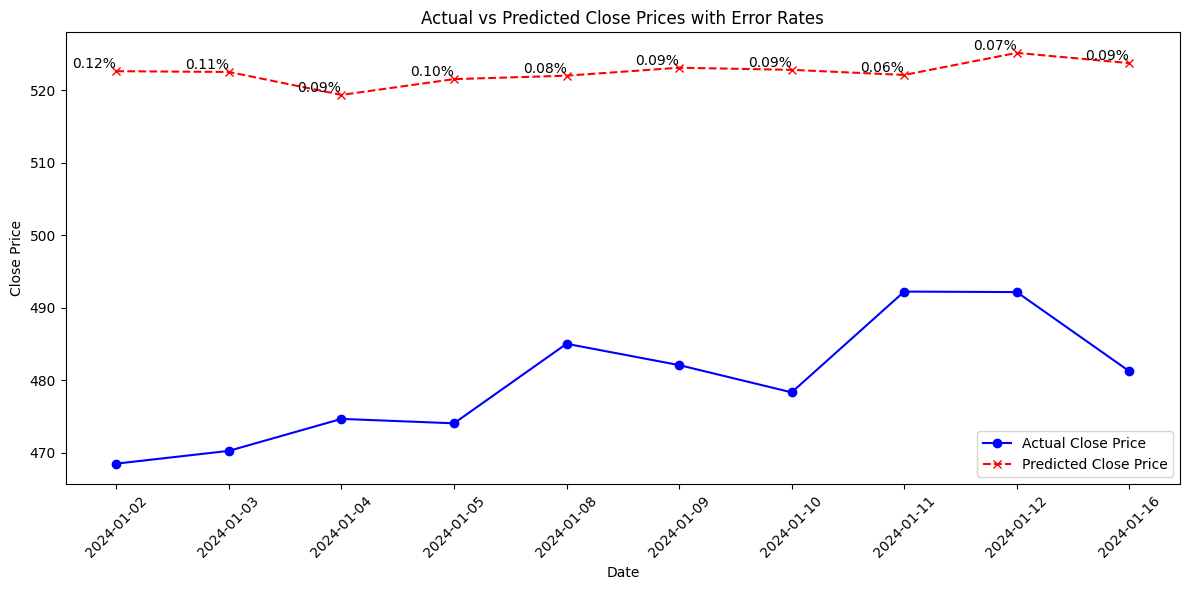

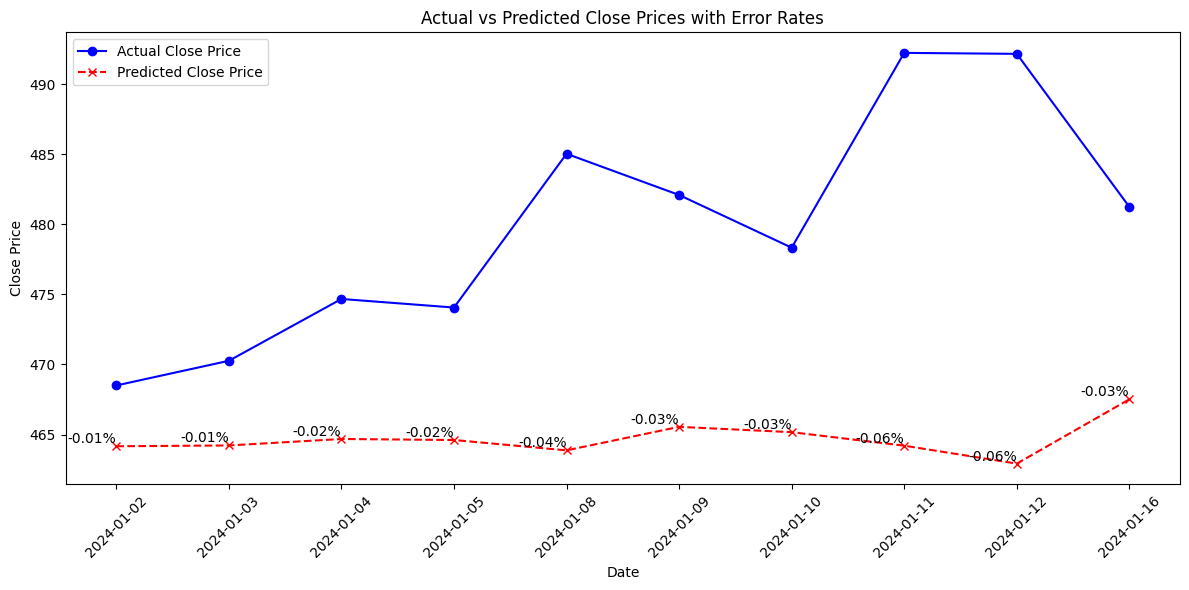

In [39]:
seq = 30
batch = 1
out = 10
hidden = 256
data = ['stock','total']
for d in data:
    path = f'../../data/results/transformer_seq{seq}_batch{batch}_out{out}_hidden{hidden}_{d}.csv'
    plot_result(path)

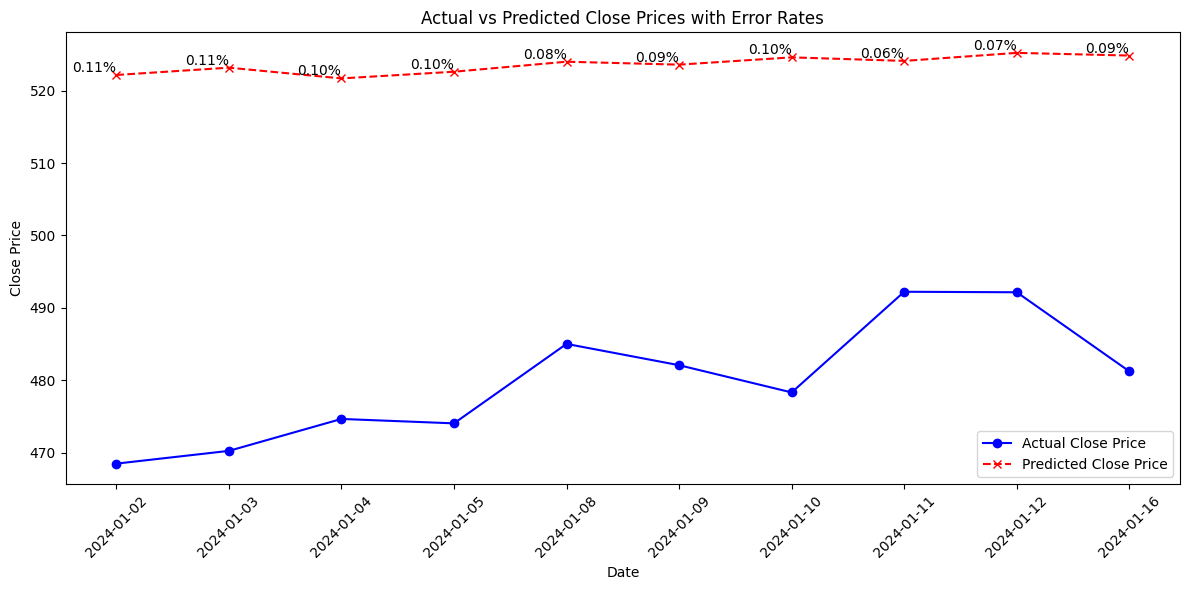

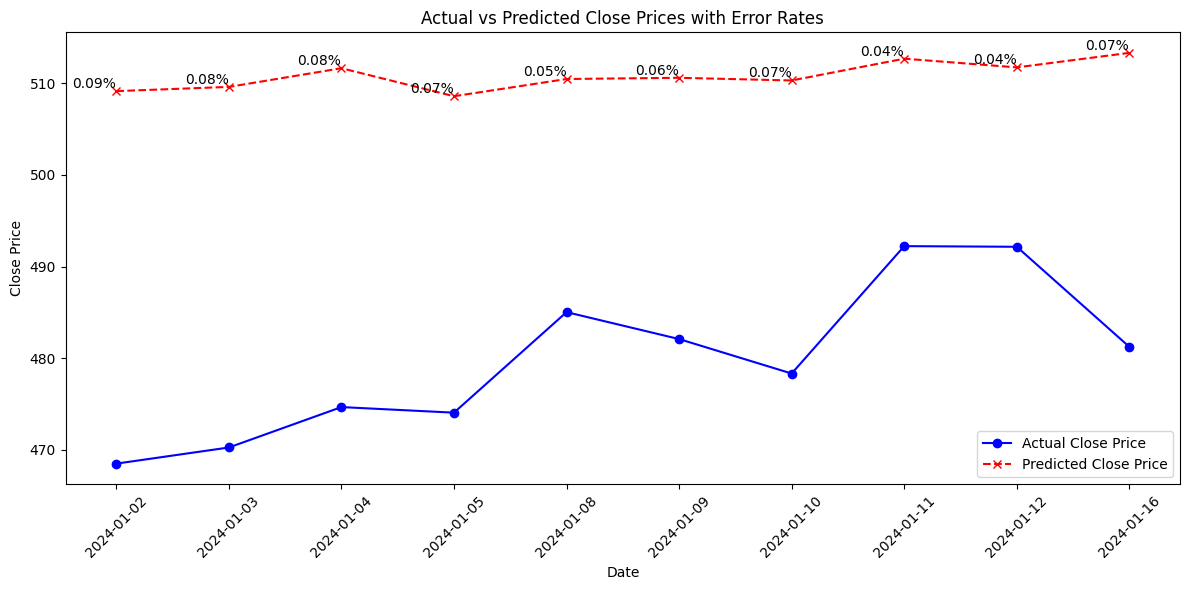

In [40]:
seq = 60
batch = 1
out = 10
hidden = 128
data = ['stock','total']
for d in data:
    path = f'../../data/results/transformer_seq{seq}_batch{batch}_out{out}_hidden{hidden}_{d}.csv'
    plot_result(path)

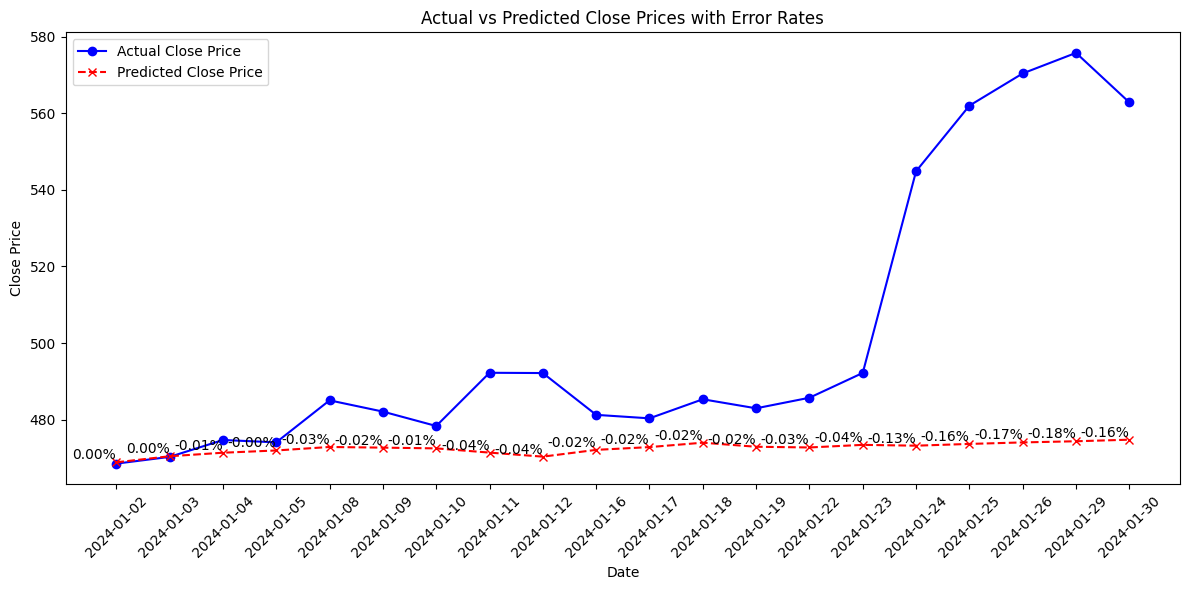

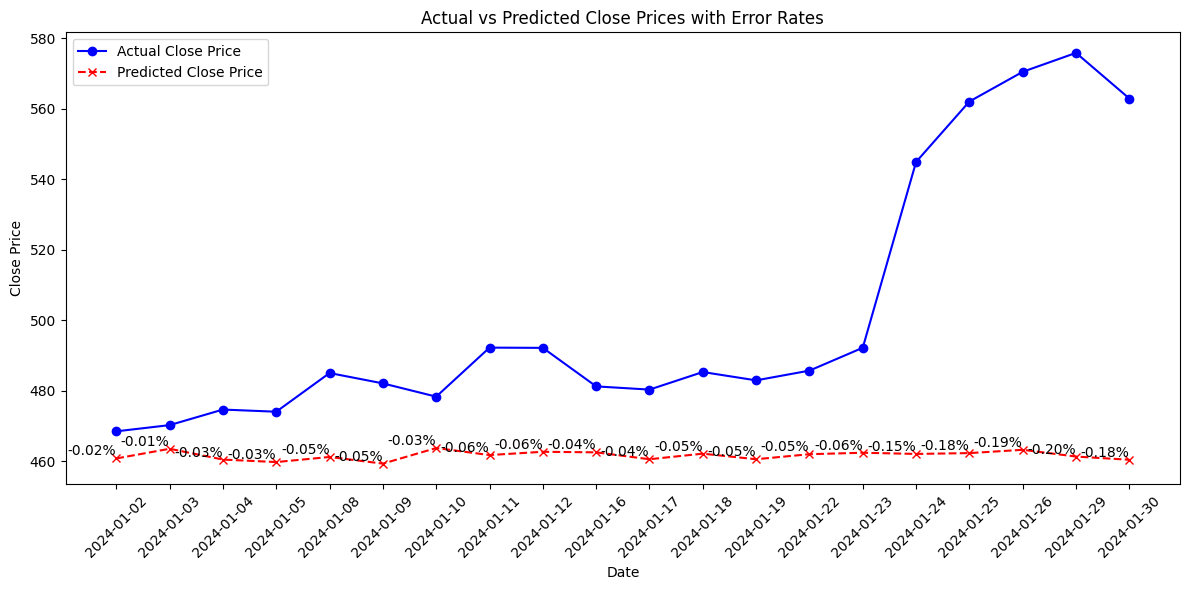

In [41]:
seq = 60
batch = 1
out = 20
hidden = 64
data = ['stock','total']
for d in data:
    path = f'../../data/results/transformer_seq{seq}_batch{batch}_out{out}_hidden{hidden}_{d}.csv'
    plot_result(path)

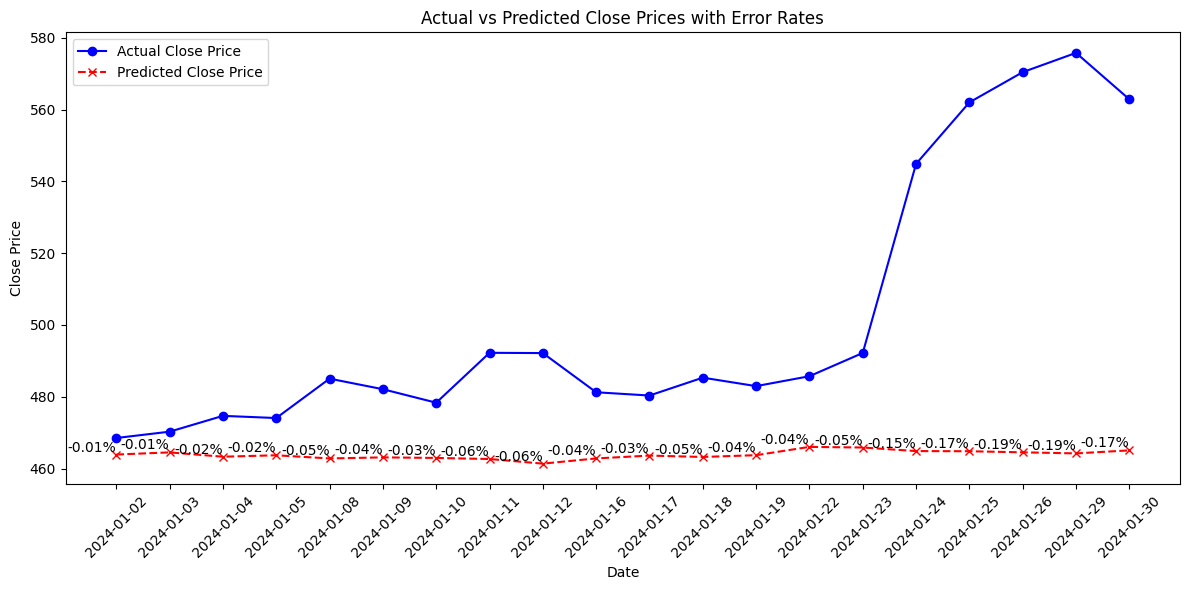

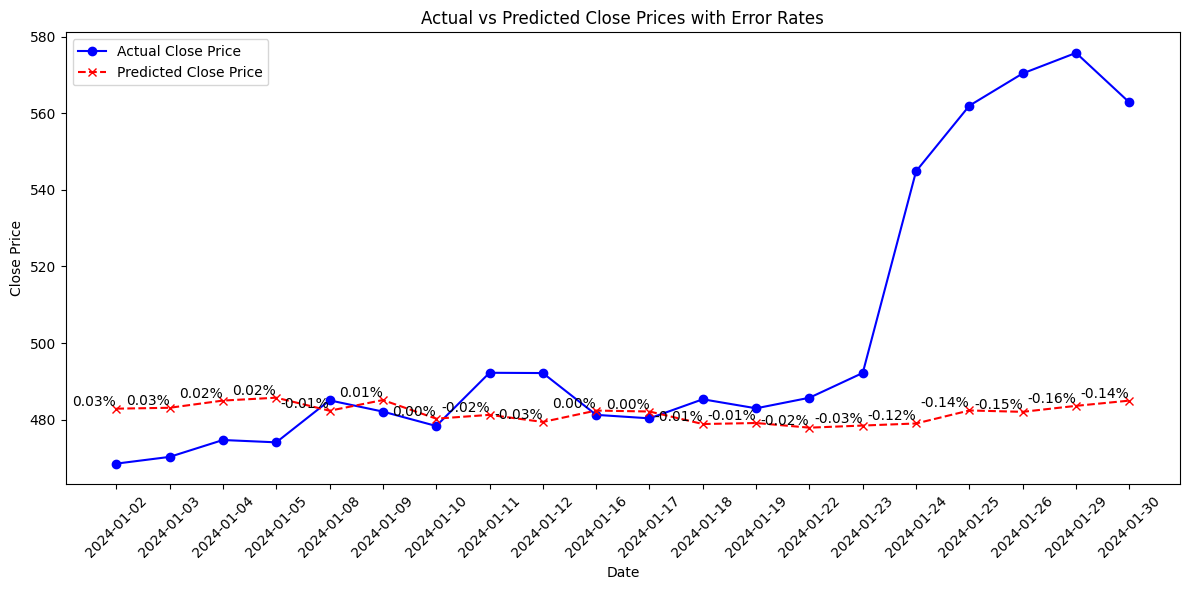

In [43]:
seq = 60
batch = 1
out = 20
hidden = 128
data = ['stock','total']
for d in data:
    path = f'../../data/results/transformer_seq{seq}_batch{batch}_out{out}_hidden{hidden}_{d}.csv'
    plot_result(path)

In [65]:
def save_plot(seq,batch,out,hidden):
    stock_path = f'../../data/results/transformer_seq{seq}_batch{batch}_out{out}_hidden{hidden}_stock.csv'
    total_path = f'../../data/results/transformer_seq{seq}_batch{batch}_out{out}_hidden{hidden}_total.csv'
    
    # read file
    stock_df = pd.read_csv(stock_path)
    total_df = pd.read_csv(total_path)
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))  # Create subplots with 2 rows and 1 column
    dfs = [stock_df, total_df]  
    titles = ['Stock', 'Total']  # Titles for each subplot

    for ax, df, title in zip(axes, dfs, titles):
        # 실제 종가 데이터
        actual_prices = df['true']

        # 날짜 데이터
        dates = df['Date']

        # 오차율 계산
        error_rate = df['error_ratio']

        # 예측값
        pred_np = df['pred']

        # 시각화
        ax.plot(dates, actual_prices, marker='o', color='blue', label='Actual Close Price')
        ax.plot(dates, pred_np, marker='x', color='red', linestyle='--', label='Predicted Close Price')

        # 오차율을 각 포인트에 텍스트로 표시
        for i, (date, actual, prediction, error) in enumerate(zip(dates, actual_prices, pred_np, error_rate)):
            ax.text(date, prediction, f'{error:.2f}%', color='black', ha='right', va='bottom')

        ax.set_xticks(ticks=list(range(len(dates))),rotation=45,
                     labels=dates)  # 날짜 레이블 회전
        ax.set_xlabel('Date')
        ax.set_ylabel('Close Price')
        ax.set_title(f'Actual vs Predicted Close Prices with Error Rates (Data: {title})')
        ax.legend()
        
    plt.tight_layout()  # 레이아웃 조정    
    plt.savefig(f'../../plots/results_shortcut/transformer_seq{seq}_batch{batch}_out{out}_hidden{hidden}.png',dpi=300)
    plt.clf()


In [67]:
SEQUENCE_SIZEs = [30,60,120]
BATCH_SIZEs = [1,5,32,64,128]
OUTPUT_SIZEs = [10,20]
HIDDEN_SIZEs = [64,128,256]
import itertools
for SEQUENCE_SIZE,BATCH_SIZE,OUTPUT_SIZE,HIDDEN_SIZE in itertools.product(SEQUENCE_SIZEs,BATCH_SIZEs,OUTPUT_SIZEs,HIDDEN_SIZEs):
    save_plot(SEQUENCE_SIZE,BATCH_SIZE,OUTPUT_SIZE,HIDDEN_SIZE)

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

In [68]:
save_plot(30,1,20,128)

<Figure size 1200x1200 with 0 Axes>

In [5]:
result_kaggle = pd.read_csv('../../data/final_results_0220.csv',index_col=0)
result_kaggle.head(3)

,data,target,seq_size,pred_size,batch_size,hidden_size,best_val_loss,mean_error_ratio
0,total_df,1d_ROC,30,10,1,64,2.308222,2.610493
1,total_df,1d_ROC,30,10,1,128,2.309499,2.064409
2,total_df,1d_ROC,30,10,4,64,2.466593,3.690737


In [6]:
result_kaggle.sort_values(by=['best_val_loss','mean_error_ratio']).reset_index(drop=True)

,data,target,seq_size,pred_size,batch_size,hidden_size,best_val_loss,mean_error_ratio
0,total_df,1d_ROC,30,10,1,64,2.308222,2.610493
1,total_df,1d_ROC,30,10,1,128,2.309499,2.064409
2,stock_df,1d_ROC,30,10,1,64,2.322184,1.848956
3,stock_df,1d_ROC,30,10,1,128,2.352901,2.306814
4,total_df,1d_ROC,30,10,4,64,2.466593,3.690737
5,stock_df,1d_ROC,120,10,1,64,2.479942,1.686736
6,total_df,1d_ROC,120,10,1,64,2.483304,3.068910
7,stock_df,1d_ROC,120,10,1,128,2.486116,3.016483
8,total_df,1d_ROC,120,10,1,128,2.500813,1.821803
9,stock_df,1d_ROC,30,10,4,64,2.522594,3.450523


In [ ]:
result_kaggle.groupby

In [7]:
result_kaggle

,data,target,seq_size,pred_size,batch_size,hidden_size,best_val_loss,mean_error_ratio
0,total_df,1d_ROC,30,10,1,64,2.308222,2.610493
1,total_df,1d_ROC,30,10,1,128,2.309499,2.064409
2,total_df,1d_ROC,30,10,4,64,2.466593,3.690737
3,total_df,1d_ROC,30,10,4,128,2.548204,2.147470
4,total_df,1d_ROC,30,10,8,64,2.580323,3.816631
5,total_df,1d_ROC,30,10,8,128,2.610420,2.336732
6,total_df,1d_ROC,60,10,1,64,2.560809,1.745235
7,total_df,1d_ROC,60,10,1,128,2.556102,3.059885
8,total_df,1d_ROC,60,10,4,64,2.722011,5.996937
9,total_df,1d_ROC,60,10,4,128,2.804026,2.085697


In [ ]:
# 시각화
label = test_df.copy()
label = np.array(label.head(PRED_SIZE)["Close Price"])

# Prediction
pred_ = preds_df['Mean'].to_numpy().reshape(PRED_SIZE)

# 날짜 데이터
period = test_df["Date"].copy()
period = [d for d in period.head(PRED_SIZE)]
d5_period = ['2023-12-22','2023-12-26','2023-12-27','2023-12-28','2023-12-29']
d5_stock = stock_df.loc[d5_period,'Close'].to_list()

# 오차율 계산
error_rate = np.abs((label - pred_) / label) * 100

plt.figure(figsize=(12, 6))
plt.plot(d5_period+period, d5_stock+label.tolist(), marker='o', color='blue', label='Actual Close Price')
plt.plot(period, pred_, marker='x', color='red', linestyle='--', label='Predicted Close Price')
plt.axvline(x='2024-01-02', color='red',linestyle='-',linewidth=.5)
# 오차율을 각 포인트에 텍스트로 표시
for date, lbl, prd, err in zip(period, label, pred_, error_rate):
    plt.text(date, prd, f'{err:.2f}%', color='black', ha='right', va='bottom')

    
plt.xticks(rotation = 45)  # 날짜 레이블 회전
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'model = {MODEL}, data = {dataname}, target = {TARGET}, seq_size = {SEQ_SIZE}, pred_size = {PRED_SIZE}, batch_size = {BATCH_SIZE}, model_size = {HIDDEN_SIZE}')
plt.legend()
plt.tight_layout()  # 레이아웃 조정
plt.savefig(f'../../plots/best_plots/10trials_{filename}.png') #### 본인 파일 경로
plt.show()
plt.clf()

# 오차율을 출력
error_rate_dict = dict(zip(period, error_rate))
# error_rate_dict

# 평균 오차율 계산
average_error_rate = np.mean(error_rate)

print(f"Average Error Rate: {average_error_rate:.2f}%")
mean_error_ratios.append(average_error_rate)